In [ ]:
from unet import UNet
import jax

## Data

Downloaded the data for segmentation from here https://www.kaggle.com/competitions/data-science-bowl-2018/data

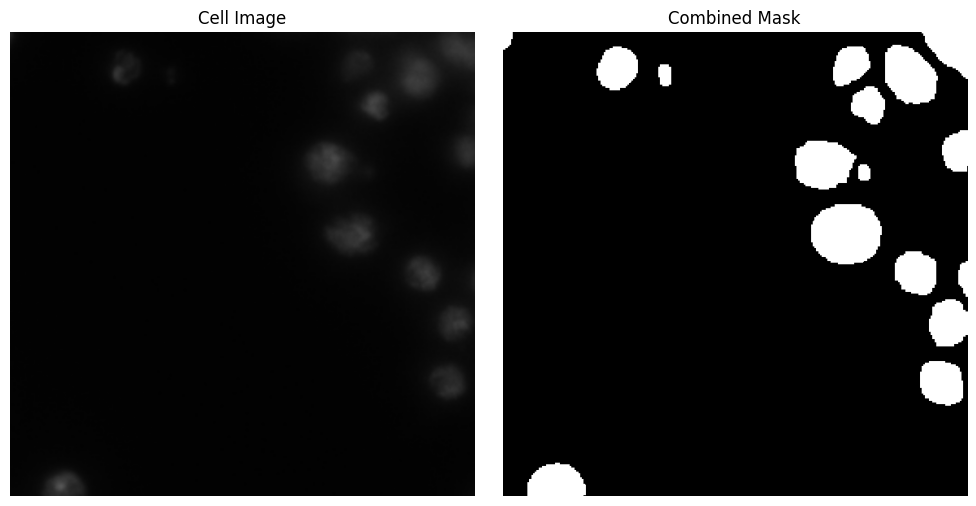

In [11]:
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


class DSB2018Dataset(Dataset):
    def __init__(self, root_dir, image_size=(572, 572)):
        self.root_dir = root_dir
        self.image_size = image_size
        self.sample_dirs = [
            os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))
         ]

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        image_path = os.path.join(sample_dir, "images", os.path.basename(sample_dir) + ".png")
        mask_dir = os.path.join(sample_dir, "masks")

        # Load and resize image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # HWC, uint8
        image = cv2.resize(image, self.image_size)
        image = image.astype(np.float32) / 255.0  # Normalize
        image = np.transpose(image, (2, 0, 1))     # (C, H, W)

        # Combine masks
        mask = np.zeros(self.image_size, dtype=np.uint8)
        for fname in os.listdir(mask_dir):
            m = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            m = cv2.resize(m, self.image_size)
            mask = np.maximum(mask, m)

        mask = (mask > 0).astype(np.float32)  # Binary mask
        mask = np.expand_dims(mask, axis=0)   # (1, H, W)

        return image, mask
    
dataset = DSB2018Dataset('./data-science-bowl-2018/stage1_train')

im, mask = dataset[0]

image_to_show = np.transpose(im, (1, 2, 0)) 
mask_to_show = mask[0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_to_show)
plt.title("Cell Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_to_show, cmap="gray")
plt.title("Combined Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

## Training the U-Net with Binary Cross-Entropy function to classify the pixels

In [ ]:
import jax.numpy as jnp

def bce_loss(logits: jnp.ndarray, targets: jnp.ndarray, eps: float = 1e-7):
    p = jax.nn.sigmoid(logits) # positive class probability
    log_sum_p = targets * jnp.log(p + eps) + (1.0 - targets) * jnp.log(1.0 - p + eps) # adding small epsilon for numerical stability here

    return jnp.mean(-log_sum_p)